## Initialisations

In [16]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
import random
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import os
import warnings
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import tree 
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [17]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [18]:
url='https://drive.google.com/file/d/1XN0P7t7koCNMcpFDTdhWQAQpv_G6yf6C/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
bank_df = pd.read_csv(url, sep=';')

## Preprocessing

In [19]:
for col in bank_df:
    bank_df = bank_df[bank_df[col] != 'unknown']

## Label Encoder

In [20]:
le = LabelEncoder()
bank_df.job = le.fit_transform(bank_df.job)
bank_df.marital = le.fit_transform(bank_df.marital)
bank_df.education = le.fit_transform(bank_df.education)
bank_df.default = le.fit_transform(bank_df.default)
bank_df.housing = le.fit_transform(bank_df.housing)
bank_df.loan = le.fit_transform(bank_df.loan)
bank_df.contact = le.fit_transform(bank_df.contact)
bank_df.month = le.fit_transform(bank_df.month)
bank_df.day_of_week = le.fit_transform(bank_df.day_of_week)
bank_df.poutcome = le.fit_transform(bank_df.poutcome)
bank_df.y = le.fit_transform(bank_df.y)

## Partitioning

In [21]:
# partition the divorced subgroup from the rest
bank_df_divorced = bank_df.copy()
bank_df_divorced = bank_df_divorced[bank_df_divorced['marital'] == 0]
bank_df_divorced.groupby('y',sort=False).size()

y
0    3143
1     410
dtype: int64

In [22]:
# sample the partition
bank_df_divorced = bank_df_divorced.groupby('y', group_keys=False).apply(lambda x: x.sample(410, random_state=64))

In [23]:
# partition the married subgroup from the rest
bank_df_married = bank_df.copy()
bank_df_married = bank_df_married[bank_df_married['marital'] == 1]
bank_df_married.groupby('y',sort=False).size()

y
0    15436
1     2056
dtype: int64

In [24]:
# sample the partition
bank_df_married = bank_df_married.groupby('y', group_keys=False).apply(lambda x: x.sample(2056, random_state=64))

In [25]:
# partition the single subgroup from the rest
bank_df_single = bank_df.copy()
bank_df_single = bank_df_single[bank_df_single['marital'] == 2]
bank_df_single.groupby('y',sort=False).size()

y
0    8050
1    1393
dtype: int64

In [26]:
# sample the partition
bank_df_single = bank_df_single.groupby('y', group_keys=False).apply(lambda x: x.sample(1393, random_state=64))

## Divorced Only Decision Tree

In [27]:
X = bank_df_divorced.drop('y',axis=1)
y = bank_df_divorced[['y']]

K-Fold

In [28]:
KF = KFold(n_splits=3,shuffle=True)
for train_index, test_index in KF.split(X):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [29]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(547, 20)
Test data shape:(273, 20)


Scaling data

In [30]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [31]:
dt = DecisionTreeClassifier()

In [32]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [33]:
pred = dt.predict(scaled_test)

In [34]:
accuracy_score(y_test,pred)

0.8315018315018315

In [35]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [36]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [37]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 0.05, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [38]:
dt_tuned =  DecisionTreeClassifier(criterion='entropy',
                                   min_samples_split=2,
                                   max_depth=6,
                                   max_features = None,
                                   min_samples_leaf=0.05,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=0.05,
                       random_state=0)

In [39]:
pred = dt_tuned.predict(scaled_test)

In [40]:
divorced_accuracy = accuracy_score(y_test,pred)

In [41]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       141
           1       0.79      0.98      0.87       132

    accuracy                           0.86       273
   macro avg       0.88      0.87      0.86       273
weighted avg       0.89      0.86      0.86       273



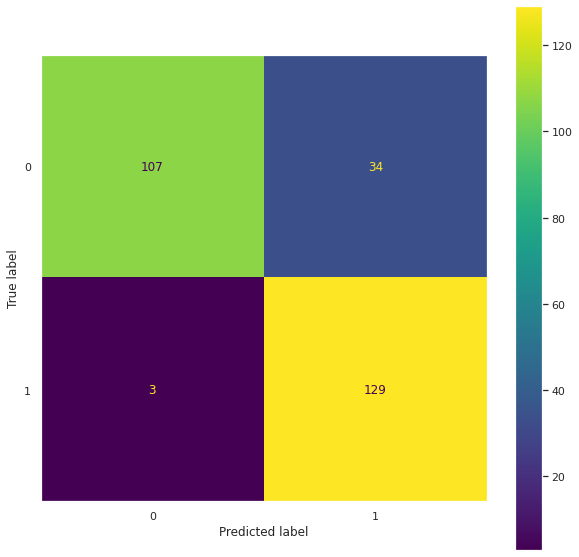

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

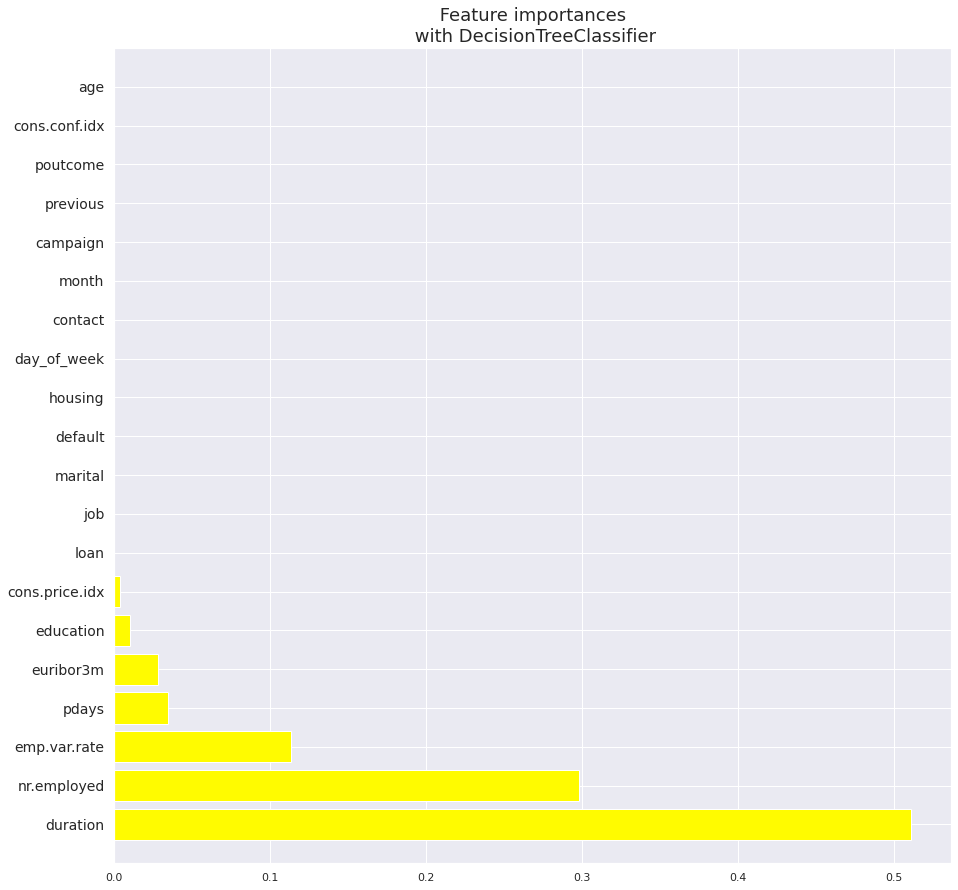

In [44]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = bank_df_divorced.drop('y', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Married Only Decision Tree

In [45]:
X = bank_df_married.drop('y',axis=1)
y = bank_df_married[['y']]

K-Fold

In [46]:
KF = KFold(n_splits=3,shuffle=True)
for train_index, test_index in KF.split(X):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [47]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(2742, 20)
Test data shape:(1370, 20)


Scaling data

In [48]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [49]:
dt = DecisionTreeClassifier()

In [50]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [51]:
pred = dt.predict(scaled_test)

In [52]:
accuracy_score(y_test,pred)

0.82992700729927

In [53]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [54]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [55]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 0.03, 'random_state': 0, 'splitter': 'best'} 


In [56]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=0.03,
                                   max_depth=8,
                                   max_features = None,
                                   min_samples_leaf=5,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=0.03,
                       random_state=0)

In [57]:
pred = dt_tuned.predict(scaled_test)

In [58]:
married_accuracy = accuracy_score(y_test,pred)

In [59]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       662
           1       0.86      0.88      0.87       708

    accuracy                           0.86      1370
   macro avg       0.86      0.86      0.86      1370
weighted avg       0.86      0.86      0.86      1370



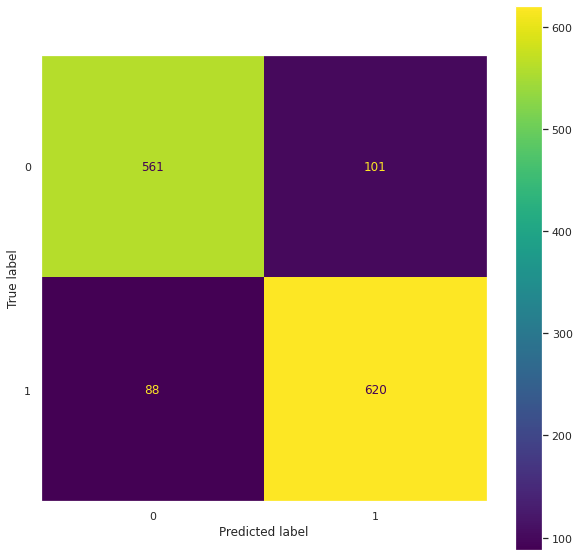

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

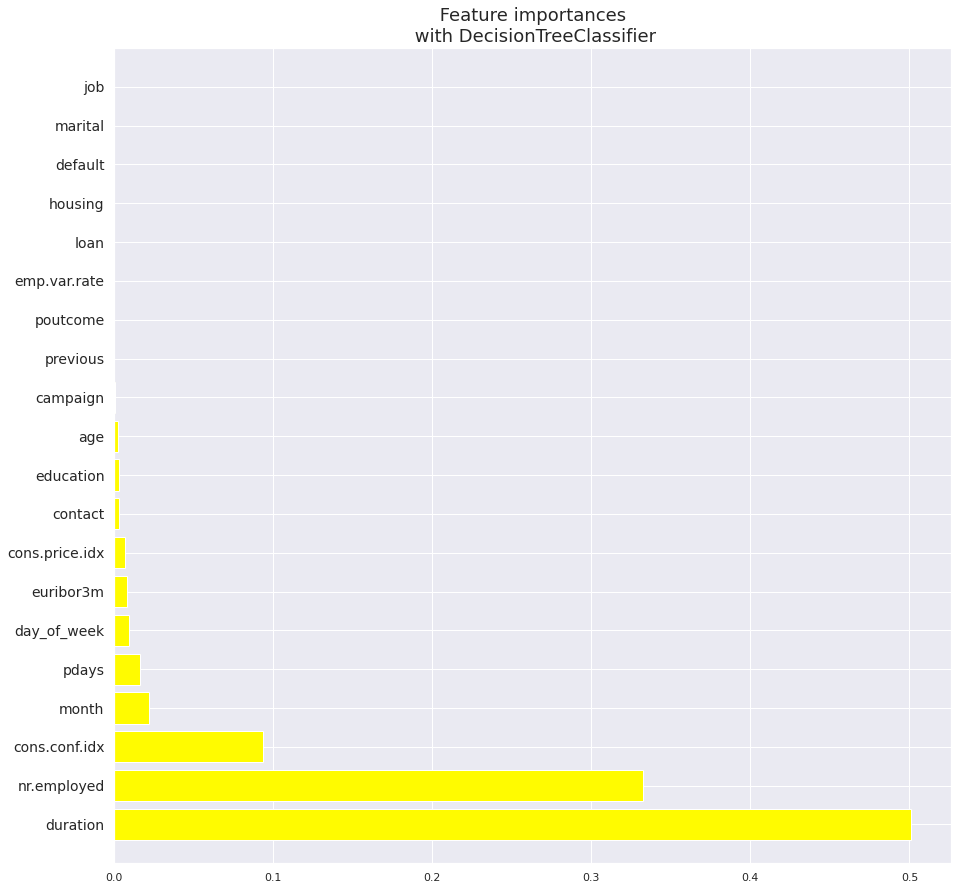

In [61]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = bank_df_married.drop('y', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Single Only Decision Tree

In [62]:
X = bank_df_single.drop('y',axis=1)
y = bank_df_single[['y']]

K-Fold

In [63]:
KF = KFold(n_splits=3,shuffle=True)
for train_index, test_index in KF.split(X):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [64]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(1858, 20)
Test data shape:(928, 20)


Scaling data

In [65]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [66]:
dt = DecisionTreeClassifier()

In [67]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [68]:
pred = dt.predict(scaled_test)

In [69]:
accuracy_score(y_test,pred)

0.7995689655172413

In [70]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [71]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [72]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 0.03, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [73]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=2,
                                   max_depth=8,
                                   max_features = None,
                                   min_samples_leaf=0.03,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=0.03, random_state=0)

In [74]:
pred = dt_tuned.predict(scaled_test)

In [75]:
single_accuracy = accuracy_score(y_test,pred)

In [76]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       461
           1       0.80      0.89      0.84       467

    accuracy                           0.83       928
   macro avg       0.84      0.83      0.83       928
weighted avg       0.84      0.83      0.83       928



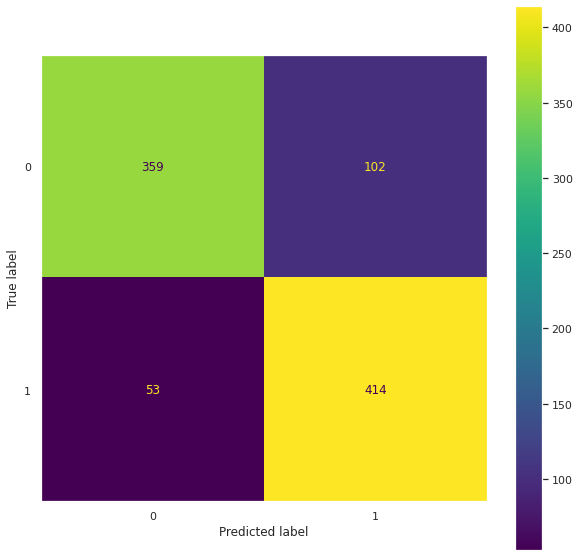

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

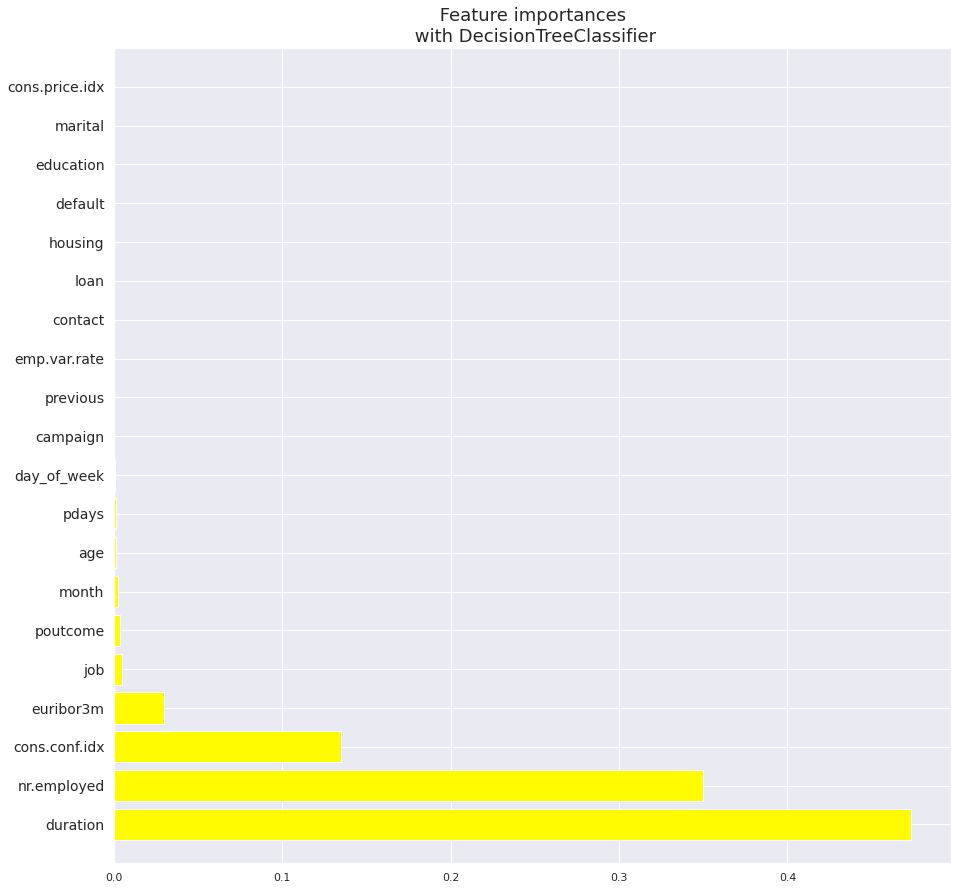

In [78]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = bank_df_single.drop('y', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Accuracy Comparison

In [79]:
from tabulate import tabulate
data = [['Divorced', divorced_accuracy],
['Married', married_accuracy],
['Single', single_accuracy]]
print (tabulate(data, headers=["Marital Status", "Classification Accuracy"]))

Marital Status      Classification Accuracy
----------------  -------------------------
Divorced                           0.864469
Married                            0.862044
Single                             0.832974
